Random Forest in sklearn

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html                
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html


Gradient Boosting                 
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html                
http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html     


XGBoost                            
http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import warnings

warnings.filterwarnings('ignore')
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

from collections import defaultdict

### Loading Training Set as padas DataFrame

In [140]:
filename = '/home/azlotn200/fx_dsa_data_train.csv'
df1      = pd.read_csv(filename,sep="|")


df = df1.copy()
TargetVar = 'target'

#Balancing data
Pdf_TargetOneD = df.loc[df[TargetVar] == 1].copy()
Pdf_TargetZeroD = df.loc[df[TargetVar] == 0].copy()
Target_ZeroD = Pdf_TargetZeroD.take(np.random.permutation(len(Pdf_TargetZeroD))[:len(df.loc[df[TargetVar] == 1])]).copy()

#Creating a final data frame
df = Pdf_TargetOneD.append(Target_ZeroD, ignore_index=True).copy()

print(df.shape)
print("===============")
print(df.dtypes)

(5046, 101)
housekey                          int64
customer_account_id               int64
account_courtesy_ind            float64
accountstatus                    object
cost_recurring_total_amt_7d     float64
cost_recurring_video_amt_7d     float64
custindicator                     int64
e_avg_bcc_creditbal100_6mo      float64
e_c_apmused_lux_car_dom_0t5     float64
e_c_comb_homeowner_renter        object
e_c_contributes_charity         float64
e_c_intrsc_plays_socce_ai       float64
e_c_intrst_audio_book_ai        float64
e_c_music_lis_alternative_ai    float64
e_c_music_lis_hip_hop_ai        float64
e_c_music_lis_pop_ai            float64
e_c_predict_amt_alcohol         float64
e_c_rm_est_cur_mort_amnt        float64
e_c_sec_indv_exact_age          float64
eml_snt_prg_prgmg                 int64
eml_snt_prg_prgmg_l14d          float64
eml_snt_prg_prgmg_l30d          float64
equip_dig_hd_xcal_cnt           float64
equip_dvr_hd_xcal_cnt           float64
equip_modem_minage          

The dataframe has 122636 observations(rows) and 100 attributes(columns). The dtypes function gives us the data type of each of the variables present in the dataset

### Check if your target variable is binary

Since we are building a model to predict the customers who will be disconnected in next 90 days, our target is going to be "target_discon90_nonpay" variable from the dataframe. Since we are implementing logistic regression, we need to ensure that the target variable is binary. To make sure that it's a binary variable, let's use the plot function from matplotlib

1    2523
0    2523
Name: target, dtype: int64


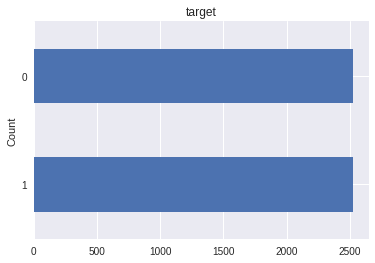

In [102]:
df[TargetVar].value_counts().plot(kind='barh')
print(df[TargetVar].value_counts())
print(" ========================")
plt.title(TargetVar)
plt.ylabel('Count')
plt.show()

### Checking for missing values

It's easy to check for missing values by calling the isnull() method, and the sum() method off of that, to return a tally of all the True values that are returned by the isnull() method.

In [103]:
df.isnull().sum()

housekey                           0
customer_account_id                0
account_courtesy_ind             121
accountstatus                      0
cost_recurring_total_amt_7d      137
cost_recurring_video_amt_7d      137
custindicator                      0
e_avg_bcc_creditbal100_6mo         1
e_c_apmused_lux_car_dom_0t5        1
e_c_comb_homeowner_renter          1
e_c_contributes_charity            1
e_c_intrsc_plays_socce_ai          1
e_c_intrst_audio_book_ai           1
e_c_music_lis_alternative_ai       1
e_c_music_lis_hip_hop_ai           1
e_c_music_lis_pop_ai               1
e_c_predict_amt_alcohol            1
e_c_rm_est_cur_mort_amnt           1
e_c_sec_indv_exact_age          3130
eml_snt_prg_prgmg                  0
eml_snt_prg_prgmg_l14d          1572
eml_snt_prg_prgmg_l30d          1572
equip_dig_hd_xcal_cnt              0
equip_dvr_hd_xcal_cnt              0
equip_modem_minage              1660
equip_xb3_wireless_gtwy_cnt        0
i_res_blg_calls_365d               0
m

### Preprocessing Treatment

Removing Redundant Columns

In [104]:
df = df.drop(['customer_account_id','housekey','prevacctid'], 1)

Dripping columns with more than 85% of missing values

In [105]:
df = df.dropna(thresh=len(df)*0.15, axis=1)

Identify object type columns
Check for cardinality of each object column
Drop High and Low cardinality columns

In [106]:
print('Columns with Object types')
print(pd.Series(df.select_dtypes(include=[object]).columns))
print('=============')
print('Cardinality')
print(df.select_dtypes(include=[object]).nunique()) 
print('=============')
print('Number of Missing')
print(df.select_dtypes(include=[object]).isnull().sum())

Columns with Object types
0                accountstatus
1    e_c_comb_homeowner_renter
2                serloc_dma_nm
3             serloc_entity_nm
dtype: object
Cardinality
accountstatus                 1
e_c_comb_homeowner_renter     7
serloc_dma_nm                89
serloc_entity_nm             37
dtype: int64
Number of Missing
accountstatus                 0
e_c_comb_homeowner_renter     1
serloc_dma_nm                35
serloc_entity_nm              0
dtype: int64


In [107]:
df = df.drop(['accountstatus','serloc_dma_nm','serloc_entity_nm'], 1)

In [108]:
df.e_c_comb_homeowner_renter = df.e_c_comb_homeowner_renter.astype(str) 

### One Hot Encoding

In [109]:
d = defaultdict(preprocessing.LabelEncoder)
df.e_c_comb_homeowner_renter = df.fillna(-999999).apply(lambda x: d[x.name].fit_transform(x))


### Splitting Target from the rest of the data frame

In [110]:
#features
df_x = df.drop(TargetVar, 1)
#target
df_y = df.loc[:, [TargetVar]]
y = df_y.values


Columns = list(df_x)
Num_Columns = list(df_x.drop(['e_c_comb_homeowner_renter'], 1))
#Num_Columns = Columns

### Dealing with outliers and Replacing missing values with mean value of columns

In [111]:
down_quantiles = df_x[Num_Columns].quantile(0.05)
up_quantiles = df_x[Num_Columns].quantile(0.95)
df_x[Num_Columns] = df_x[Num_Columns].mask(df_x < down_quantiles, down_quantiles, axis=1)   
df_x[Num_Columns] = df_x[Num_Columns].mask(df_x > up_quantiles, up_quantiles, axis=1)

In [112]:
#updated features with cleaned data
df_x = df_x.apply(lambda x:x.fillna(x.mean()))
x = df_x.values

## Generating Training and Testing Sets

In [113]:
dfX_train, dfX_test, dfy_train, dfy_test = train_test_split(df_x, df_y, test_size = .3, random_state=25)
X_train = dfX_train.values 
X_test = dfX_test.values
y_train = dfy_train.values 
y_test = dfy_test.values

The train_test_split function splits the dataset in train and test. We will develop the model on the training data set and test it on the test dataset. We do this because we do not want the model to overfit on the train dataset

## Building and Evaluating the Random Forest Model

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


# Creating a random forest classifier. 
clf = RandomForestClassifier(n_estimators=100, max_depth = 3, verbose = 2)

# Training the classifier
clf.fit(X_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

In [130]:
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)
probs_train = clf.predict_proba(X_train)
probs = clf.predict_proba(X_test)

scoreTrain = probs_train[:,1]
scoreTest = probs[:,1]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [131]:
 #Importance of Features
Importance = list(zip(dfX_train, clf.feature_importances_))
I = pd.DataFrame(Importance)
I = I.rename(columns = {0: "Features", 1: "Score"})
I = I.sort_values('Score', ascending=False)
#Printing the Important variables
print(I)

                        Features     Score
27                 num_free_vods  0.138535
76          vi_minsperacctvodmin  0.113151
26                 num_free_ests  0.092712
55        ttl_vod_purchase_price  0.059726
29                 num_paid_vods  0.055407
84       vi_tot_vod_programs_cnt  0.047506
37              svcs_premium_hbo  0.043436
2    cost_recurring_video_amt_7d  0.042008
83           vi_tot_vod_chan_cnt  0.040770
86                  vid_cost_amt  0.036319
75                vi_hbo_max_vod  0.027134
87      vid_programming_cost_amt  0.022409
34                   sho_mos_svc  0.022219
1    cost_recurring_total_amt_7d  0.020777
50                  ttl_cost_amt  0.020054
72            vi_generic_max_vod  0.019389
38         svcs_premium_showtime  0.019061
45              svcs_x1_platform  0.017297
46                        tenure  0.012686
44         svcs_x1_days_on_books  0.011977
24    mrc_recurring_total_amt_1m  0.009606
35  svcs_dayssince_mostrecent_x1  0.009326
43      svc

Selecting Top N Features based on the selection factor

In [132]:
#TopFeatures = list(I[(I['Score']>0.01)].Features)
#TopFeatures.append('target')

## Check Precision and Recall from Confusion Matrix

### Training Set

In [133]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
confusion_matrix = confusion_matrix(y_train, y_pred_train)
pd.DataFrame(confusion_matrix)

,0,1
0,1262,523
1,494,1253


In [134]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
acc = accuracy_score(y_train,y_pred_train)
rec=recall_score(y_train,y_pred_train)
pres=precision_score(y_train,y_pred_train)
print ('Accuracy:', acc)
print ('Recall:', rec)
print ('Precision:', pres)

Accuracy: 0.712061155153
Recall: 0.717229536348
Precision: 0.705518018018


### Testing Set

In [135]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
confusion_matrix = confusion_matrix(y_test, y_pred)
pd.DataFrame(confusion_matrix)

,0,1
0,502,236
1,202,574


In [136]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
acc = accuracy_score(y_test,y_pred)
rec=recall_score(y_test,y_pred)
pres=precision_score(y_test,y_pred)
print ('Accuracy:', acc)
print ('Recall:', rec)
print ('Precision:', pres)

Accuracy: 0.7107001321
Recall: 0.739690721649
Precision: 0.708641975309


## ROC curve

In [137]:
def Performance(Model,Y,X):
    # Perforamnce of the model
    fpr, tpr, _ = roc_curve(Y, Model.predict_proba(X)[:,1])
    AUC  = auc(fpr, tpr)
    print ('the AUC is : %0.4f' %  AUC)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

### Training Set

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


the AUC is : 0.7955


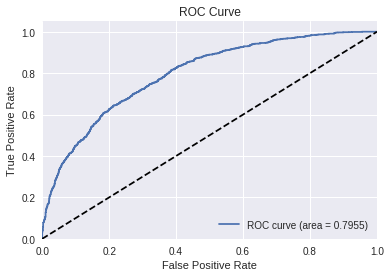

In [138]:
Performance(Model=clf,Y=y_train,X=X_train)

### Testing Set

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


the AUC is : 0.7897


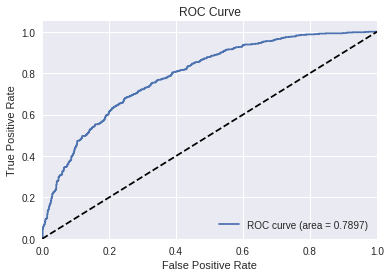

In [139]:
Performance(Model=clf,Y=y_test,X=X_test)

## KS Statistic

In [125]:
# %load /home/mbagav200/Documentation_scripts/Deciles_script.py
from collections import OrderedDict
import pandas as pd
import sys


decile_color = 'skyblue'
ks_color = 'yellow'


def plot_pandas_style(styler):
    from IPython.core.display import HTML
    html = '\n'.join([line.lstrip() for line in styler.render().split('\n')])
    return HTML(html)

def highlight_max(s,color='yellow'):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: {}'.format(color) if v else '' for v in is_max]

def decile_labels(agg1,label,color='skyblue'):
    agg_dummy = pd.DataFrame(OrderedDict((('TOTAL',0),('TARGET',0),('NONTARGET',0),('PCT_TAR',0),('CUM_TAR',0),('CUM_NONTAR',0),('DIST_TAR',0),('DIST_NONTAR',0),('SPREAD',0))),index=[0])
    agg1 = agg1.append(agg_dummy).sort_index()
    agg1.index.name = label
    agg1 = agg1.style.apply(highlight_max, color = ks_color, subset=['SPREAD'])
    agg1.bar(subset=['TARGET'], color='{}'.format(color))
    agg1.bar(subset=['TOTAL'], color='{}'.format(color))
    agg1.bar(subset=['PCT_TAR'], color='{}'.format(color))
    return(agg1)

def deciling(data,decile_by,target,nontarget):
    inputs = list(decile_by)
    inputs.extend((target,nontarget))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({},index=[])
    agg1['TOTAL'] = grouped.sum()[nontarget] + grouped.sum()[target]
    agg1['TARGET'] = grouped.sum()[target]
    agg1['NONTARGET'] = grouped.sum()[nontarget]
    agg1['PCT_TAR'] = grouped.mean()[target]*100
    
    if len(decile_by) > 1:
        agg1['CUM_TAR'] = grouped.sum()[target].groupby(level=[0]).cumsum()
        agg1['CUM_NONTAR'] = grouped.sum()[nontarget].groupby(level=[0]).cumsum()
        agg1['DIST_TAR'] = agg1['CUM_TAR']/agg1['TARGET'].groupby(level=[0]).sum()*100
        agg1['DIST_NONTAR'] = agg1['CUM_NONTAR']/agg1['NONTARGET'].groupby(level=[0]).sum()*100
        agg1['SPREAD'] = (agg1['DIST_TAR'] - agg1['DIST_NONTAR'])
        d = {}
        
        if agg1.index.names[0] == 'DIVISION':
            loop = DIVISIONS
        elif agg1.index.names[0] == 'REGION':
            loop = REGIONS
    
        for i in loop:
            x = loop.index(i)
            d[x] = agg1.ix[i]
            d[x] = decile_labels(d[x],i,color=decile_color)
            d[x] = plot_pandas_style(d[x])    
        return(d)
    else:
        agg1['CUM_TAR'] = grouped.sum()[target].cumsum()
        agg1['CUM_NONTAR'] = grouped.sum()[nontarget].cumsum()
        agg1['DIST_TAR'] = agg1['CUM_TAR']/agg1['TARGET'].sum()*100
        agg1['DIST_NONTAR'] = agg1['CUM_NONTAR']/agg1['NONTARGET'].sum()*100
        agg1['SPREAD'] = (agg1['DIST_TAR'] - agg1['DIST_NONTAR'])
        agg1 = decile_labels(agg1,'NATIONAL',color=decile_color)
        return(plot_pandas_style(agg1))


In [126]:
def KS(probability_results, test_labels):
    # DEFINE 10 BUCKETS WITH EQUAL SIZE
    Probability = pd.DataFrame(probability_results, columns = ["miss", "score"])
    good = pd.DataFrame(test_labels, columns = ["good"])
    Final = pd.concat([Probability, good], axis=1)
    Final["bad"] = 1 - Final.good
    #Final['bucket'] = pd.qcut(Final.score, 10)
    
    Final['DECILE'] = pd.qcut(Final['score'],10,labels=False)
    Final['DECILE'] = 10 - Final['DECILE']
    
    DecileTable = deciling(Final,['DECILE'],'good','bad')

    %matplotlib inline
    return DecileTable

### Training

In [127]:
KS(probs_train, y_train)

,TOTAL,TARGET,NONTARGET,PCT_TAR,CUM_TAR,CUM_NONTAR,DIST_TAR,DIST_NONTAR,SPREAD
NATIONAL,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
1,354,323,31,91.2429,323,31,18.4888,1.73669,16.7521
2,353,277,76,78.4703,600,107,34.3446,5.9944,28.3502
3,353,244,109,69.1218,844,216,48.3114,12.1008,36.2106
4,353,227,126,64.3059,1071,342,61.3051,19.1597,42.1454
5,353,181,172,51.2748,1252,514,71.6657,28.7955,42.8702
6,353,174,179,49.2918,1426,693,81.6256,38.8235,42.8021
7,353,140,213,39.6601,1566,906,89.6394,50.7563,38.8831
8,353,93,260,26.3456,1659,1166,94.9628,65.3221,29.6407


### Testing

In [128]:
KS(probs, y_test)

,TOTAL,TARGET,NONTARGET,PCT_TAR,CUM_TAR,CUM_NONTAR,DIST_TAR,DIST_NONTAR,SPREAD
NATIONAL,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
1,152,132,20,86.8421,132,20,17.0103,2.71003,14.3003
2,151,128,23,84.7682,260,43,33.5052,5.82656,27.6786
3,151,105,46,69.5364,365,89,47.0361,12.0596,34.9765
4,152,95,57,62.5,460,146,59.2784,19.7832,39.4952
5,151,86,65,56.9536,546,211,70.3608,28.5908,41.77
6,151,78,73,51.6556,624,284,80.4124,38.4824,41.93
7,152,64,88,42.1053,688,372,88.6598,50.4065,38.2533
8,151,49,102,32.4503,737,474,94.9742,64.2276,30.7466


## Gains Plot

In [578]:
# %load /home/mbagav200/Documentation_scripts/Actual_Predicted.py
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt

def plots(agg1,target,type):

	plt.figure(1,figsize=(20, 5))

	plt.subplot(131)
	plt.plot(agg1['DECILE'],agg1['ACTUAL'],label='Actual')
	plt.plot(agg1['DECILE'],agg1['PRED'],label='Pred')
	plt.xticks(range(10,110,10))
	plt.legend(fontsize=15)
	plt.grid(True)
	plt.title('Actual vs Predicted', fontsize=20)
	plt.xlabel("Population %",fontsize=15)
	plt.ylabel(str(target) + " " + str(type) + " %",fontsize=15)

	plt.subplot(132)
	X = agg1['DECILE'].tolist()
	X.append(0)
	Y = agg1['DIST_TAR'].tolist()
	Y.append(0)
	plt.plot(sorted(X),sorted(Y))
	plt.plot([0, 100], [0, 100],'r--')
	plt.xticks(range(0,110,10))
	plt.yticks(range(0,110,10))
	plt.grid(True)
	plt.title('Gains Chart', fontsize=20)
	plt.xlabel("Population %",fontsize=15)
	plt.ylabel(str(target) + str(" DISTRIBUTION") + " %",fontsize=15)
	plt.annotate(round(agg1[agg1['DECILE'] == 30].DIST_TAR.item(),2),xy=[30,30], 
				 xytext=(25, agg1[agg1['DECILE'] == 30].DIST_TAR.item() + 5),fontsize = 13)
	plt.annotate(round(agg1[agg1['DECILE'] == 50].DIST_TAR.item(),2),xy=[50,50], 
				 xytext=(45, agg1[agg1['DECILE'] == 50].DIST_TAR.item() + 5),fontsize = 13)

	plt.subplot(133)
	plt.plot(agg1['DECILE'],agg1['LIFT'])
	plt.xticks(range(10,110,10))
	plt.grid(True)
	plt.title('Lift Chart', fontsize=20)
	plt.xlabel("Population %",fontsize=15)
	plt.ylabel("Lift",fontsize=15)

	plt.tight_layout()

def dec_plots(agg1,target,type):
	
	Northeast = agg1[agg1['DIVISION'] == 'NORTHEAST DIVISION']
	Northeast.name = 'Northeast'
	Central = agg1[agg1['DIVISION'] == 'CENTRAL DIVISION']
	Central.name = 'Central'
	West = agg1[agg1['DIVISION'] == 'WEST DIVISION']
	West.name = 'West'
	
	plt.figure(1,figsize=(20, 5))

	plt.subplot(131)
	for i in [Northeast,Central,West]:
		plt.plot(i['DECILE'],i['ACTUAL'],label=i.name + ' - Actual')
		plt.plot(i['DECILE'],i['PRED'],label=i.name + ' - Pred')
	plt.xticks(range(10,110,10))
	plt.legend(fontsize=12)
	plt.grid(True)
	plt.title('Actual vs Predicted', fontsize=20)
	plt.xlabel("Population %",fontsize=15)
	plt.ylabel(str(target) + " " + str(type) + " %",fontsize=15)

	plt.subplot(132)
	for i in [Northeast,Central,West]:
		X = i['DECILE'].tolist()
		X.append(0)
		Y = i['DIST_TAR'].tolist()
		Y.append(0)
		plt.plot(sorted(X),sorted(Y),label= i.name)
	plt.xticks(range(0,110,10))
	plt.plot([0, 100], [0, 100],'r--')
	plt.yticks(range(0,110,10))
	plt.legend(fontsize=12)
	plt.grid(True)
	plt.title('Gains Chart', fontsize=20)
	plt.xlabel("Population %",fontsize=15)
	plt.ylabel(str(target) + str(" DISTRIBUTION") + " %",fontsize=15)
	

	plt.subplot(133)
	for i in [Northeast,Central,West]:
		plt.plot(i['DECILE'],i['LIFT'], label = i.name)
	plt.xticks(range(10,110,10))
	plt.legend(fontsize=12)
	plt.grid(True)
	plt.title('Lift Chart', fontsize=20)
	plt.xlabel("Population %",fontsize=15)
	plt.ylabel("Lift",fontsize=15)

	plt.tight_layout()

	
def reg_plots(agg1,target,type):
	
	CALIFORNIA = agg1[agg1['REGION'] == 'CALIFORNIA REGION']
	FLORIDA = agg1[agg1['REGION'] == 'FLORIDA REGION']
	CHICAGO = agg1[agg1['REGION'] == 'CHICAGO REGION']
	BIG = agg1[agg1['REGION'] == 'BIG SOUTH REGION']
	FREEDOM = agg1[agg1['REGION'] == 'FREEDOM REGION']
	GREATER = agg1[agg1['REGION'] == 'GREATER BOSTON REGION']
	BELTWAY = agg1[agg1['REGION'] == 'BELTWAY REGION']
	MOUNTAIN = agg1[agg1['REGION'] == 'MOUNTAIN WEST REGION']
	HEARTLAND = agg1[agg1['REGION'] == 'HEARTLAND REGION']
	KEYSTONE = agg1[agg1['REGION'] == 'KEYSTONE REGION']
	SEATTLE = agg1[agg1['REGION'] == 'SEATTLE REGION']
	WESTERN = agg1[agg1['REGION'] == 'WESTERN NEW ENGLAND REGION']
	PORTLAND = agg1[agg1['REGION'] == 'PORTLAND REGION']
	TWIN = agg1[agg1['REGION'] == 'TWIN CITIES REGION']
	HOUSTON = agg1[agg1['REGION'] == 'HOUSTON REGION']
	
	CALIFORNIA.name = 'California'
	FLORIDA.name = 'Florida'
	CHICAGO.name = 'Chicago'
	BIG.name = 'Big South'
	FREEDOM.name = 'Freedom'
	GREATER.name = 'Greater Boston'
	BELTWAY.name = 'Beltway'
	MOUNTAIN.name = 'Mountain West'
	HEARTLAND.name = 'Heartland'
	KEYSTONE.name = 'Keystone'
	SEATTLE.name = 'Seattle'
	WESTERN.name = 'Western New England'
	PORTLAND.name = 'PORTLAND'
	TWIN.name = 'Twin Cities'
	HOUSTON.name = 'Houston'
	
	plt.figure(1,figsize=(20, 5))
	plt.subplot(131)
	for i in [FREEDOM,GREATER,BELTWAY,KEYSTONE,WESTERN]:
		X = i['DECILE'].tolist()
		X.append(0)
		Y = i['DIST_TAR'].tolist()
		Y.append(0)
		plt.plot(sorted(X),sorted(Y),label= i.name)
	plt.plot([0, 100], [0, 100],'r--')
	plt.xticks(range(0,110,10))
	plt.yticks(range(0,110,10))
	plt.legend(fontsize=12)
	plt.grid(True)
	plt.title('Gains Chart - Northeast Division', fontsize=15)
	plt.xlabel("Population %",fontsize=15)
	plt.ylabel(str(target) + str(" DISTRIBUTION") + " %",fontsize=15)

	plt.subplot(132)
	for i in [FLORIDA,CHICAGO,BIG,HEARTLAND]:
		X = i['DECILE'].tolist()
		X.append(0)
		Y = i['DIST_TAR'].tolist()
		Y.append(0)
		plt.plot(sorted(X),sorted(Y),label= i.name)
	plt.plot([0, 100], [0, 100],'r--')
	plt.xticks(range(0,110,10))
	plt.yticks(range(0,110,10))
	plt.legend(fontsize=12)
	plt.grid(True)
	plt.title('Gains Chart - Central Division', fontsize=15)
	plt.xlabel("Population %",fontsize=15)
	plt.ylabel(str(target) + str(" DISTRIBUTION") + " %",fontsize=15)
	

	plt.subplot(133)
	for i in [CALIFORNIA,MOUNTAIN,SEATTLE,PORTLAND,TWIN,HOUSTON]:
		X = i['DECILE'].tolist()
		X.append(0)
		Y = i['DIST_TAR'].tolist()
		Y.append(0)
		plt.plot(sorted(X),sorted(Y),label= i.name)
	plt.plot([0, 100], [0, 100],'r--')
	plt.xticks(range(0,110,10))
	plt.yticks(range(0,110,10))
	plt.legend(fontsize=12)
	plt.grid(True)
	plt.title('Gains Chart - West Division', fontsize=15)
	plt.xlabel("Population %",fontsize=15)
	plt.ylabel(str(target) + str(" DISTRIBUTION") + " %",fontsize=15)

	plt.tight_layout()
	
def gains(data,decile_by,target,score,type):
	inputs = list(decile_by)
	inputs.extend((target,score))
	decile = data[inputs]
	check = decile[decile_by].max()
	if check.isin([10]).any():
		multiplier = 10
	else:
		multiplier = 1
	grouped = decile.groupby(decile_by)
	agg1 = pd.DataFrame({},index=[])
	agg1['ACTUAL'] = grouped.mean()[target]*100
	agg1['PRED'] = grouped.mean()[score]*100
    
	if len(decile_by) > 1:
		agg1['DIST_TAR'] = grouped.sum()[target].groupby(level=[0]).cumsum()/grouped.sum()[target].groupby(level=[0]).sum()*100
		agg1 = agg1.reset_index()
		if agg1.columns[0:1].item() == 'REGION':
			agg1=agg1.rename(columns = {agg1.columns[1:2].item():'DECILE'})
		elif agg1.columns[0:1].item() == 'DIVISION':
			agg1=agg1.rename(columns = {agg1.columns[1:2].item():'DECILE'})
		
		agg1['DECILE'] = agg1['DECILE']*multiplier
		agg1['LIFT'] = agg1['DIST_TAR']/agg1['DECILE']
		
		if agg1.columns[0:1].item() == 'REGION':
			reg_plots(agg1,target,type)
		elif agg1.columns[0:1].item() == 'DIVISION':
			dec_plots(agg1,target,type)
	else:
		agg1['DIST_TAR'] = grouped.sum()[target].cumsum()/grouped.sum()[target].sum()*100
		agg1.index.name = 'DECILE'
		agg1 = agg1.reset_index()
		agg1['DECILE'] = agg1['DECILE']*multiplier
		agg1['LIFT'] = agg1['DIST_TAR']/agg1['DECILE']
		plots(agg1,target,type)

### Training Set

In [579]:
dfX_Score = pd.concat([dfX_train, dfy_train], axis=1)

model_variables = dfX_Score.columns.tolist() 
    
model_variables = [dfX_Score.upper() for dfX_Score in model_variables]

dfX_Score['SCORE'] = scoreTrain

dfX_Score['DECILE'] = pd.qcut(dfX_Score['SCORE'],10,labels=range(10,0,-1) )
dfX_Score['DECILE'] = dfX_Score['DECILE'].astype(float)

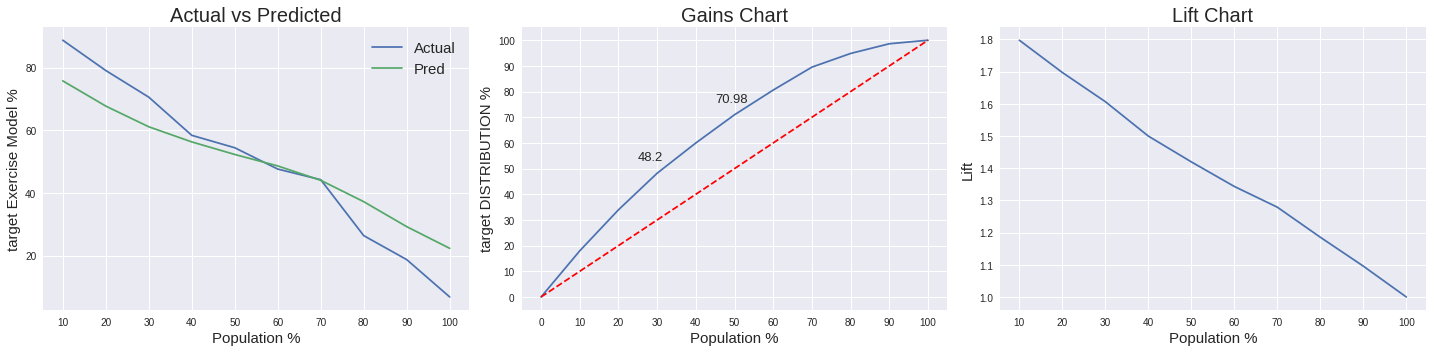

In [580]:
%matplotlib inline
gains(dfX_Score,['DECILE'],TargetVar,'SCORE','Exercise Model')

### Testing Set

In [581]:
dfX_ScoreTest = pd.concat([dfX_test, dfy_test], axis=1)

model_variables = dfX_ScoreTest.columns.tolist() 
    
model_variables = [dfX_ScoreTest.upper() for dfX_ScoreTest in model_variables]

dfX_ScoreTest['SCORE'] = scoreTest

dfX_ScoreTest['DECILE'] = pd.qcut(dfX_ScoreTest['SCORE'],10,labels=range(10,0,-1) )
dfX_ScoreTest['DECILE'] = dfX_ScoreTest['DECILE'].astype(float)

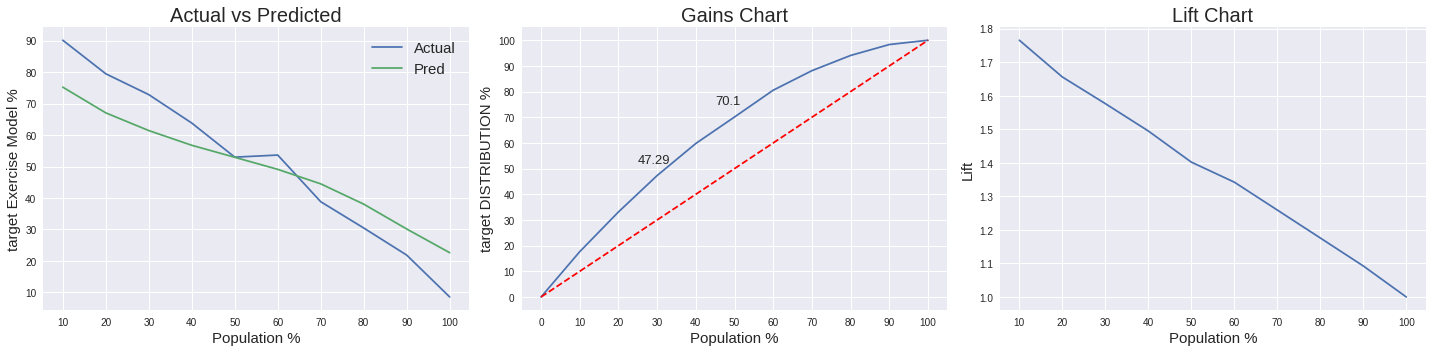

In [582]:
%matplotlib inline
gains(dfX_ScoreTest,['DECILE'],TargetVar,'SCORE','Exercise Model')